In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# functions

In [2]:
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

def plot_errors(plotcols, test_data, train_data):
    test_diff = test_data['outofsample_error']
    train_diff = train_data['insample_error']
    
    test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
    test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
    test_plot = test_data[plotcols].copy().drop_duplicates()
    
    train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
    train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
    train_plot = train_data[plotcols].copy().drop_duplicates()
    
    trainx = pd.date_range(start=min(train_data.index),end=max(train_data.index),periods=train_plot.shape[0])
    testx = pd.date_range(start=min(test_data.index),end=max(test_data.index),periods=test_plot.shape[0])
    
    fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
    for i,col in enumerate(plotcols):
        axs[i].plot(trainx,train_plot[col],color='green',label='in-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    for i,col in enumerate(plotcols):
        axs[i].plot(testx,test_plot[col],color='purple',label='out-of-sample')
        axs[i].set_title(col.replace('_',' '))
        axs[i].legend()
    plt.show()

def retrain(old_train_data,old_test_data,train_to_date):
    new_train = pd.concat([old_train_data,old_test_data[old_test_data.index<=train_to_date]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False)
    new_test = old_test_data[~old_test_data.index.isin(new_train['calculation_date'])].copy().reset_index(drop=False)
    arrs = trainer.get_train_test_arrays(new_train, new_test)
    train_X = arrs['train_X']
    train_y = arrs['train_y']
    test_X = arrs['test_X']
    test_y = arrs['test_y']
    preprocessor = trainer.preprocess()
    retrained_model = trainer.run_dnn(preprocessor,train_X,train_y)
    train_test = trainer.test_prediction_accuracy(new_train,new_test,retrained_model)
    new_test_data = train_test['test_data'].set_index('calculation_date')
    new_train_data = train_test['train_data'].set_index('calculation_date')
    print()
    plot_errors(plotcols,new_test_data,new_train_data)
    return new_train_data, new_test_data

# loading model

In [3]:
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
models = [f for f in os.listdir(models_dir) if f.find('.')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     2024_11_01 180435470848 short-term cboe asians
1     2024_11_01 195924619203 live cboe barriers
2     2024_11_01 204910611379 bloomberg barriers
3     2024_11_01 205356527985 bloomberg asians
4     2024_11_02 113141414136 cboe asians
5     2024_11_02 113706914873 cboe barriers


# loading data

0     2024_11_02 113706914873 cboe barriers test_data.csv
1     2024_11_02 113706914873 cboe barriers train_data.csv
2     2024_11_02 113706914873 cboe barriers.pkl

spot price 
0       5177.00
1       5178.50
2       5178.75
3       5179.00
4       5189.00
         ...   
1276    5864.25
1277    5864.50
1278    5865.00
1279    5865.50
1280    5866.50
Name: spot_price, Length: 1281, dtype: float64

strike price 
0        4659.300
1        4660.650
2        4660.875
3        4661.100
4        4670.100
           ...   
11322    6450.675
11323    6450.950
11324    6451.500
11325    6452.050
11326    6453.150
Name: strike_price, Length: 11327, dtype: float64

days to maturity 
0     60
1     90
2    180
3    360
4    540
5    720
Name: days_to_maturity, dtype: int64

risk free rate 
0    0.04
Name: risk_free_rate, dtype: float64

dividend rate 
0    0.0
Name: dividend_rate, dtype: float64

kappa 
0         0.000824
1         0.001284
2         0.002276
3         0.003055
4         0.00306

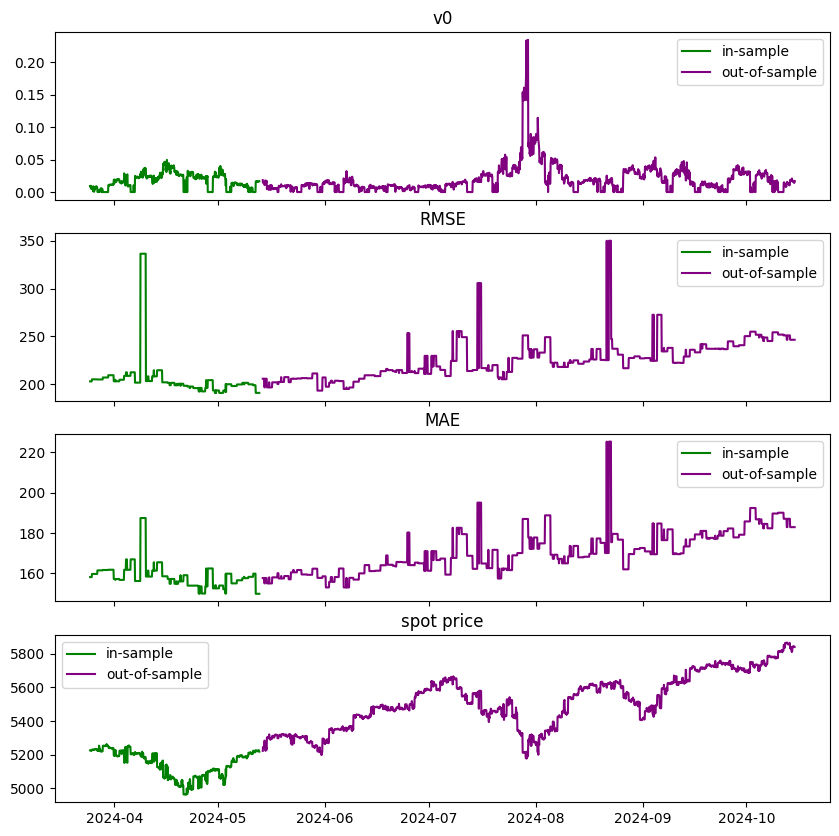

,spot_price,strike_price,barrier,days_to_maturity,updown,outin,w,barrier_type_name,rebate,dividend_rate,...,eta,v0,date,barrier_price,observed_price,outofsample_target,outofsample_prediction,outofsample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2024-05-14,5222.25,5091.69375,5274.47250,60,Up,Out,call,UpOut,0.0,0.0,...,2.530278,0.018425,2024-05-15,7.166750,7.143179,7.143179,164.070147,156.926968,205.586317,157.695949
2024-05-14,5245.25,4720.72500,6582.78875,60,Up,Out,call,UpOut,0.0,0.0,...,1.168135,0.014216,2024-05-15,567.172726,567.164429,567.164429,164.070147,-403.094282,205.586317,157.695949
2024-05-14,5245.25,4720.72500,6582.78875,60,Up,Out,put,UpOut,0.0,0.0,...,1.168135,0.014216,2024-05-15,14.053164,14.014196,14.014196,164.070147,150.055951,205.586317,157.695949
2024-05-14,5245.25,4720.72500,6582.78875,60,Up,In,call,UpIn,0.0,0.0,...,1.168135,0.014216,2024-05-15,2.685790,2.677932,2.677932,164.070147,161.392215,205.586317,157.695949
2024-05-14,5245.25,4720.72500,6582.78875,90,Up,Out,call,UpOut,0.0,0.0,...,1.168135,0.014216,2024-05-15,585.584795,585.600952,585.600952,164.070147,-421.530805,205.586317,157.695949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-15,5840.25,5256.22500,2920.12500,90,Down,Out,put,DownOut,0.0,0.0,...,2.056881,0.017049,2024-10-16,35.116654,35.137320,35.137320,164.070147,128.932826,246.359781,182.921704
2024-10-15,5840.25,5256.22500,2920.12500,90,Down,Out,call,DownOut,0.0,0.0,...,2.056881,0.017049,2024-10-16,680.130599,680.134906,680.134906,164.070147,-516.064760,246.359781,182.921704
2024-10-15,5840.25,5256.22500,2920.12500,60,Down,In,put,DownIn,0.0,0.0,...,2.056881,0.017049,2024-10-16,0.744872,0.736397,0.736397,164.070147,163.333750,246.359781,182.921704


In [4]:
"""
select model here
"""
model = models[-1]
""""""

plotcols = ['v0','RMSE', 'MAE','spot_price']

from convsklearn import asian_trainer, barrier_trainer

model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")
print()
if any('asian' in file for file in model_files):
    trainer = asian_trainer
if any('barrier' in file for file in model_files):
    trainer = barrier_trainer

train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('train')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('test')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date']).dt.normalize()
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date']).dt.normalize()
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
test_dates = pd.Series(test_data.index).sort_values(ascending=True).drop_duplicates().reset_index(drop=True)
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))

for col in trainer.feature_set:
    print(f"{col.replace("_"," "):}",f"\n{test_data[col].copy().squeeze().sort_values().drop_duplicates().reset_index(drop=True)}\n")
print()
print(model_fit)

plot_errors(plotcols, test_data, train_data)
test_data

# retraining

In [5]:
retraining_frequency = 5
retraining_i = np.arange(retraining_frequency,len(test_dates),retraining_frequency)
retraining_dates = test_dates[retraining_i].reset_index(drop=True)
print(retraining_dates)

0    2024-05-21
1    2024-05-29
2    2024-06-05
3    2024-06-12
4    2024-06-20
5    2024-06-27
6    2024-07-05
7    2024-07-12
8    2024-07-19
9    2024-07-26
10   2024-08-02
11   2024-08-09
12   2024-08-16
13   2024-08-23
14   2024-08-30
15   2024-09-09
16   2024-09-16
17   2024-09-23
18   2024-09-30
19   2024-10-07
20   2024-10-14
Name: calculation_date, dtype: datetime64[ns]



Tue May 21 00:00:00 2024

training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001
cpu: 399.33540391921997

in sample:
     RMSE: 61.595880696166425
     MAE: 24.12436427297864

out of sample:
     RMSE: 72.8725703683127
     MAE: 44.391175075241115



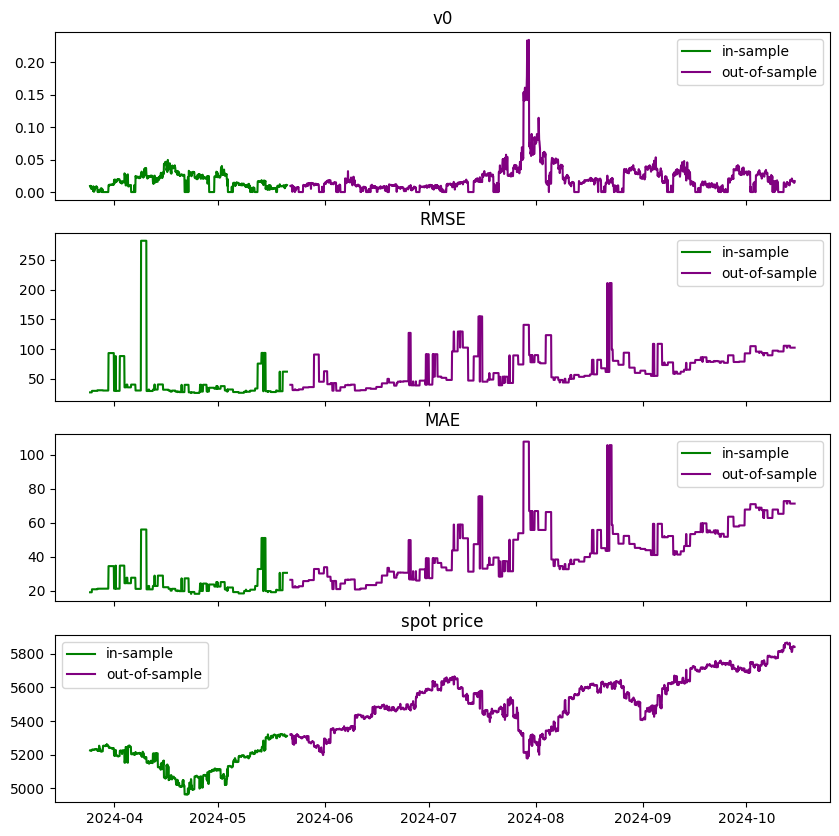



Wed May 29 00:00:00 2024

training...

alpha: 0.01
hidden_layer_sizes: (13, 13)
learning_rate: adaptive
learning_rate_init: 0.1
solver: sgd
early_stopping: False
max_iter: 500
warm_start: True
tol: 0.0001


In [ ]:
for date in retraining_dates:
    print()
    print(date.strftime('%c'))
    retrain(train_data,test_data,date)
    print()